### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of Spanish-English sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into Spanish-English pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

In [5]:
spa_eng.shape

(123770, 3)

Estos datos tienen un total de 123,770 pares de oraciones.  Sin embargo, utilizaremos los primeros 70,000 pares de oraciones solo para reducir el tiempo de entrenamiento del modelo. Puede cambiar este número según la potencia de cálculo del sistema.

In [7]:
spa_eng = spa_eng[:70000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [8]:
spa_eng[10000]

array(["What's at stake?", '¿Qué está en peligro?',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #2234064 (CK) & #5863997 (albrusgher)'],
      dtype='<U278')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [9]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [10]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

No tiene en cuenta signos típicos españoles, por lo que también vamos a quitar `¡` y `¿`:

In [11]:
import re

In [12]:
spa_eng[:,0] = [re.sub('¡|¿','',s) for s in spa_eng[:,0]]
spa_eng[:,1] = [re.sub('¡|¿','',s) for s in spa_eng[:,1]]

In [13]:
spa_eng[10000]

array(['Whats at stake', 'Qué está en peligro',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #2234064 (CK) & #5863997 (albrusgher)'],
      dtype='<U278')

In [14]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()

In [15]:
spa_eng[10000]

array(['whats at stake', 'qué está en peligro',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #2234064 (CK) & #5863997 (albrusgher)'],
      dtype='<U278')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for Spanish and English, respectively.

In [16]:
# empty lists
spa_l = []
eng_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,1]: # Las frases en español están en la segunda columna
    spa_l.append(len(i.split()))

for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

In [17]:
length_df = pd.DataFrame({'spa':spa_l, 'eng':eng_l})
print(length_df)
print(max(length_df.spa))
print(max(length_df.eng))

       spa  eng
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
69995    8    8
69996    6    6
69997    9    7
69998    7    7
69999    6    7

[70000 rows x 2 columns]
15
9


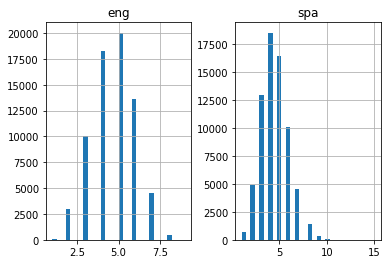

In [18]:
length_df.hist(bins = 30)
plt.show()

In [19]:
max(length_df.eng)

9

In [20]:
max(length_df.spa)

15

The maximum length of the Spanish sentences is 15 and that of the English phrases is 10.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

Vamos a rellenar estas secuencias con ceros para hacer todas las secuencias de la misma longitud.

In [21]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [22]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 9
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 8644


In [23]:
# prepare spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 9
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 16782


In [24]:
type(spa_tokenizer.word_counts)

collections.OrderedDict

In [25]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 161), ('vete', 46), ('vaya', 74), ('váyase', 8), ('hola', 22), ('corre', 25), ('corran', 4), ('corra', 3), ('corred', 4), ('quién', 728), ('órale', 10), ('fuego', 60), ('incendio', 13), ('disparad', 3), ('ayuda', 255), ('socorro', 2), ('auxilio', 3), ('salta', 4), ('salte', 2), ('parad', 2), ('para', 1182), ('pare', 7), ('espera', 88), ('esperen', 11), ('continúa', 17), ('continúe', 8), ('me', 4564), ('oculté', 1), ('escondí', 4), ('ocultaba', 1), ('escondía', 1), ('corrí', 15), ('corría', 6), ('lo', 3219), ('intento', 14), ('he', 685), ('ganado', 21), ('oh', 13), ('no', 9549), ('tomátelo', 2), ('con', 1701), ('soda', 3), ('disparen', 1), ('dispara', 1), ('dispará', 1), ('dispare', 3), ('sonríe', 8), ('al', 1105), ('ataque', 13), ('atacad', 1), ('ataquen', 1), ('ataca', 1), ('levanta', 25), ('ahora', 702), ('mismo', 228), ('id', 7), ('vayan', 13), ('ya', 567), ('tengo', 1299), ('pillas', 1), ('entendiste', 6), ('él', 3652), ('corrió', 36), ('métete', 6), ('adentro',

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [26]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [27]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode Spanish sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [28]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[  76    9  225 ...  322    0    0]
 [7384   24  139 ...    0    0    0]
 [   1   13  180 ...    0    0    0]
 ...
 [  54   23  267 ...    0    0    0]
 [4183  390    0 ...    0    0    0]
 [  10 4269    8 ...    0    0    0]]
56000
[[  7  50   5 ... 376   0   0]
 [856   9  45 ...   0   0   0]
 [  3 378 890 ...   0   0   0]
 ...
 [ 48   6 827 ...   0   0   0]
 [ 46   2  70 ...   0   0   0]
 [  2 404  13 ...   0   0   0]]
56000


In [29]:
print(trainX.shape)
print(trainY.shape)

(56000, 9)
(56000, 9)


In [30]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[   45    48     4 ...     0     0     0]
 [   16    18    47 ...    82     0     0]
 [    1    13  1224 ...     0     0     0]
 ...
 [   10   231   627 ...     0     0     0]
 [  655     1    52 ... 16234     3   544]
 [   19    48   321 ...     0     0     0]]
14000
[[ 12 134   7 ...   0   0   0]
 [ 59  14   3 ...   0   0   0]
 [  3 242 157 ...   0   0   0]
 ...
 [  1 264   1 ...   0   0   0]
 [283   3  77 ...   0   0   0]
 [ 13 134   7 ...   0   0   0]]
14000


In [31]:
print(testX.shape)
print(testY.shape)

(14000, 9)
(14000, 9)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [32]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) #False -> RNN
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [33]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

16782
8644
9
9


In [34]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

Voy a ejecutarlo cambiando el callback por `EarlyStopping` porque no tengo espacio en disco disponible en mi ordenador.

In [35]:
filename = 'model.h1.24_jan_19'
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# 'No space left on device' --> CheckPoint Early Stopping
checkpoint = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #verbose 1 -> Para que pinte los cambios

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44800 samples, validate on 11200 samples
Epoch 1/30
44800/44800 [==============================] - 3238s 72ms/step - loss: 3.7490 - val_loss: 3.3003
Epoch 2/30
44800/44800 [==============================] - 416s 9ms/step - loss: 3.1846 - val_loss: 3.1187
Epoch 3/30
44800/44800 [==============================] - 367s 8ms/step - loss: 3.0069 - val_loss: 3.0080
Epoch 4/30
44800/44800 [==============================] - 372s 8ms/step - loss: 2.8657 - val_loss: 2.8684
Epoch 5/30
44800/44800 [==============================] - 405s 9ms/step - loss: 2.7094 - val_loss: 2.7402
Epoch 6/30
44800/44800 [==============================] - 374s 8ms/step - loss: 2.5557 - val_loss: 2.6183
Epoch 7/30
44800/44800 [==============================] - 385s 9ms/step - loss: 2.4149 - val_loss: 2.5126
Epoch 8/30
44800/44800 [==============================] - 365s 8ms/step - loss: 2.2776 - val_loss: 2.4216
Epoch 9/30
44800/44800 [==============================] - 2626s 59ms/step - loss: 2.1474 - val_loss:

Let's compare the training loss and the validation loss.

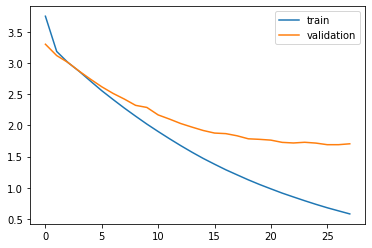

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [37]:
#model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [38]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [39]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [40]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [41]:
pred_df.head(15)

,actual,predicted
0,this house is famous,this house is famous
1,why was tom fired,why did tom get toms
2,tom took off his shoes,tom took off shoes
3,do you have guests for dinner,do you have any
4,history tends to repeat itself,the story made to
5,tom usually keeps appointments,tom felt 300 his word
6,dont beat around the bush,dont beat around the bush
7,stop being nosey,stop be to
8,i seem to have lost my purse,i was me to my
9,he isnt perfect,its not perfect


In [42]:
pred_df.tail(15)

,actual,predicted
13985,its a simple job,its a job
13986,her hair is wet with sweat,my son is in tears
13987,i cant understand,i cant understand
13988,i agree with him so do i,i agree him but all
13989,the painter died young,her man was died young
13990,warn tom,leave tom
13991,everybody was looking for tom,everybody was looking tom
13992,i love that movie,i like this movie
13993,tom put up his umbrella,tom opened his jacket
13994,they live nearby,they live in


In [43]:
pred_df.tail(15)

,actual,predicted
13985,its a simple job,its a job
13986,her hair is wet with sweat,my son is in tears
13987,i cant understand,i cant understand
13988,i agree with him so do i,i agree him but all
13989,the painter died young,her man was died young
13990,warn tom,leave tom
13991,everybody was looking for tom,everybody was looking tom
13992,i love that movie,i like this movie
13993,tom put up his umbrella,tom opened his jacket
13994,they live nearby,they live in


In [44]:
pred_df.sample(15)

,actual,predicted
880,the sun is setting,the rose is over
9294,tom pulled the trigger,tom opened the
7200,you are very elegant,youre very skeptical
4971,im attaching three files,i am under three
9784,please put the books in order,put the book for please
13847,tom often screens his calls,tom often taken to his parents
8138,she married him,she married him
4261,i have a great life,i have a very good
11241,can tom help us,tom can help us
12580,theyre cold,theyre cold


* Train new model

In [45]:
model2 = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 256)
rms = optimizers.RMSprop(lr=0.001)
model2.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

Voy a ejecutarlo cambiando el callback por `EarlyStopping` porque no tengo espacio en disco disponible en mi ordenador.

 ### Ejecutando otros modelos con diferente tamaño de batch size:
  #### BS = 1024

In [46]:
filename = 'model.h1.24_jan_19'
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# 'No space left on device' --> callback: Early Stopping
checkpoint = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #verbose 1 -> Para que pinte los cambios

history2 = model2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=256, #Duplico el batch size y hago más pequeño el learning rate
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44800 samples, validate on 11200 samples
Epoch 1/30
44800/44800 [==============================] - 226s 5ms/step - loss: 3.6988 - val_loss: 3.2783
Epoch 2/30
44800/44800 [==============================] - 782s 17ms/step - loss: 3.1767 - val_loss: 3.1075
Epoch 3/30
44800/44800 [==============================] - 1055s 24ms/step - loss: 3.0049 - val_loss: 3.0015
Epoch 4/30
44800/44800 [==============================] - 209s 5ms/step - loss: 2.8552 - val_loss: 2.8477
Epoch 5/30
44800/44800 [==============================] - 210s 5ms/step - loss: 2.6777 - val_loss: 2.6886
Epoch 6/30
44800/44800 [==============================] - 209s 5ms/step - loss: 2.5245 - val_loss: 2.5828
Epoch 7/30
44800/44800 [==============================] - 210s 5ms/step - loss: 2.3947 - val_loss: 2.4737
Epoch 8/30
44800/44800 [==============================] - 209s 5ms/step - loss: 2.2719 - val_loss: 2.3787
Epoch 9/30
44800/44800 [==============================] - 218s 5ms/step - loss: 2.1598 - val_loss: 

Let's compare the training loss and the validation loss.

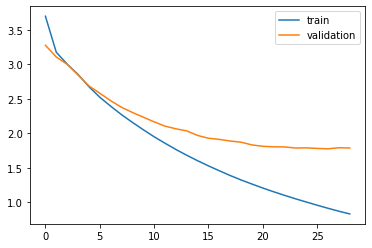

In [48]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Haciendo más pequeño el learning rate se evita el sobreentrenamiento, la curva de entrenamiento y validación es muy similar, pero la pérdida (loss) es mucho mayor, es decir, habrá mayor error en las predicciones. Para comprobarlo voy a hacer predicciones nuevas usando este nuevo modelo:

### Make Predictions

Let's load the saved model to make predictions.

In [49]:
#model = load_model('model.h1.24_jan_19')
preds = model2.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [50]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [51]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [52]:
pd.set_option('display.max_colwidth', 200)

In [53]:
pred_df.head(15)

,actual,predicted
0,this house is famous,this house is small
1,why was tom fired,why was tom go home
2,tom took off his shoes,tom took off his shoes
3,do you have guests for dinner,you any
4,history tends to repeat itself,a story tried to true
5,tom usually keeps appointments,tom never mary his age
6,dont beat around the bush,dont beat around the bush
7,stop being nosey,stop being quit
8,i seem to have lost my purse,i seems you had my
9,he isnt perfect,its not perfect


In [54]:
pred_df.tail(15)

,actual,predicted
13985,its a simple job,its a job
13986,her hair is wet with sweat,her hair is studying with
13987,i cant understand,i cant understand
13988,i agree with him so do i,i agree of
13989,the painter died young,her young died a young
13990,warn tom,find tom
13991,everybody was looking for tom,everyone all looking for
13992,i love that movie,i like that movie
13993,tom put up his umbrella,tom opened his umbrella
13994,they live nearby,they live close


In [56]:
pred_df.sample(15)

,actual,predicted
1466,im afraid tom will get lost,im afraid tom wont it
1405,i dont care about the expense,i not care on
3987,you just missed it,did you try for him
3020,i just moved,i just lost out
3236,he is a famous baseball player,hes a of citizen singer
11673,thats it im outta here,its already
11327,tom cant be that naive,tom cant be very
7378,please sit,please sit down
8727,it sounds easy,it seems easy
8126,the enemy is weak,the river is dirty


* Try with another model

In [234]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [57]:
filename = 'model.h1.24_jan_19'

checkpoint = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #verbose 1 -> Para que pinte los cambios
                                            # Evitar overfitting
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=40, batch_size=256, #Duplico el batch size y hago más pequeño el learning rate
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 44800 samples, validate on 11200 samples
Epoch 1/40
44800/44800 [==============================] - 433s 10ms/step - loss: 0.5770 - val_loss: 1.7021
Epoch 2/40
44800/44800 [==============================] - 390s 9ms/step - loss: 0.5491 - val_loss: 1.7092
Epoch 3/40
44800/44800 [==============================] - 392s 9ms/step - loss: 0.5121 - val_loss: 1.7174
Epoch 00003: early stopping


Let's compare the training loss and the validation loss.

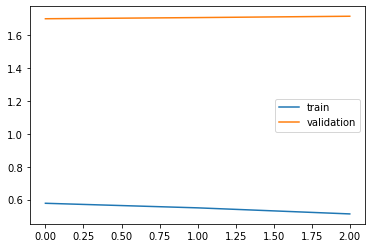

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [59]:
model3 = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 1024)
rms = optimizers.RMSprop(lr=0.001)
model3.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [60]:
filename = 'model.h1.24_jan_19'

checkpoint = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #verbose 1 -> Para que pinte los cambios
                                            # Evitar overfitting
history = model3.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=40, batch_size=1024, #Duplico el batch size y hago más pequeño el learning rate
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44800 samples, validate on 11200 samples
Epoch 1/40
44800/44800 [==============================] - 781s 17ms/step - loss: 3.9785 - val_loss: 3.5313
Epoch 2/40
44800/44800 [==============================] - 763s 17ms/step - loss: 3.2356 - val_loss: 3.1655
Epoch 3/40
44800/44800 [==============================] - 835s 19ms/step - loss: 3.0635 - val_loss: 3.0399
Epoch 4/40
44800/44800 [==============================] - 3950s 88ms/step - loss: 2.8623 - val_loss: 2.9169
Epoch 5/40
44800/44800 [==============================] - 741s 17ms/step - loss: 2.6867 - val_loss: 2.7054
Epoch 6/40
44800/44800 [==============================] - 733s 16ms/step - loss: 2.5146 - val_loss: 2.5924
Epoch 7/40
44800/44800 [==============================] - 740s 17ms/step - loss: 2.3499 - val_loss: 2.4563
Epoch 8/40
44800/44800 [==============================] - 727s 16ms/step - loss: 2.1897 - val_loss: 2.3621
Epoch 9/40
44800/44800 [==============================] - 727s 16ms/step - loss: 2.0386 - val

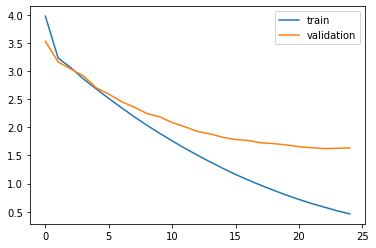

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [66]:
#model = load_model('model.h1.24_jan_19')
preds = model3.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [67]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [68]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [69]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [70]:
pd.set_option('display.max_colwidth', 200)

In [71]:
pred_df.head(15)

,actual,predicted
0,this house is famous,this house is quiet
1,why was tom fired,why did tom do of job
2,tom took off his shoes,tom put out his shoes
3,do you have guests for dinner,do you have other
4,history tends to repeat itself,the story needs to more
5,tom usually keeps appointments,tom should packed his
6,dont beat around the bush,dont beat around the bush
7,stop being nosey,stop to
8,i seem to have lost my purse,i had to my
9,he isnt perfect,its not perfect


In [72]:
pred_df.tail(15)

,actual,predicted
13985,its a simple job,its a job
13986,her hair is wet with sweat,her hair is full of
13987,i cant understand,i cant understand it
13988,i agree with him so do i,i agree with him
13989,the painter died young,his wife died young
13990,warn tom,tom
13991,everybody was looking for tom,everyone but tom
13992,i love that movie,i like that movie
13993,tom put up his umbrella,tom opened his offer
13994,they live nearby,they live peace


In [73]:
pred_df.tail(15)

,actual,predicted
13985,its a simple job,its a job
13986,her hair is wet with sweat,her hair is full of
13987,i cant understand,i cant understand it
13988,i agree with him so do i,i agree with him
13989,the painter died young,his wife died young
13990,warn tom,tom
13991,everybody was looking for tom,everyone but tom
13992,i love that movie,i like that movie
13993,tom put up his umbrella,tom opened his offer
13994,they live nearby,they live peace


In [74]:
pred_df.sample(15)

,actual,predicted
6375,its my turn now,its my turn
4170,i dont feel like doing it,i dont mind nor it do
11606,im just killing time,im just the time
8337,she can speak spanish,can speak to
11557,i missed you today,i you today
3096,these are toms ski boots,these are toms
8624,what year were you born,what year were you born
12121,im a normal girl,im a boy
7067,lets leave early,lets eat later
10133,tom was like a father to mary,tom was like mary


# Trying another models
## Simple RNN model

### Read Data

In [6]:
data = read_text("spa-eng/spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

In [7]:
len(spa_eng)

123770

In [8]:
spa_eng = spa_eng[:120000,:]

In [9]:
spa_eng[50000]

array(['Fill out this form, please.',
       'Rellene este formulario, por favor.',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #58537 (CK) & #737938 (Shishir)'],
      dtype='<U278')

### Text Pre-Processing

In [10]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [11]:
spa_eng[:,0] = [re.sub('¡|¿','',s) for s in spa_eng[:,0]]
spa_eng[:,1] = [re.sub('¡|¿','',s) for s in spa_eng[:,1]]

In [12]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()

In [13]:
# empty lists
spa_l = []
eng_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,1]: # Las frases en español están en la segunda columna
    spa_l.append(len(i.split()))

for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

In [14]:
length_df = pd.DataFrame({'spa':spa_l, 'eng':eng_l})
print(length_df)
print(max(length_df.spa))
print(max(length_df.eng))

        spa  eng
0         1    1
1         1    1
2         1    1
3         1    1
4         1    1
...     ...  ...
119995   10   11
119996   12   14
119997   11   13
119998   15   14
119999   11   12

[120000 rows x 2 columns]
20
15


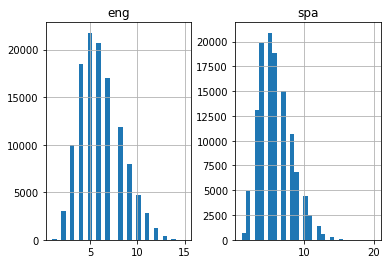

In [15]:
length_df.hist(bins = 30)
plt.show()

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [19]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 4 #Voy a coger las más cortas
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 12986


In [20]:
# prepare spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 4 #Quiero más cortas
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 25261


### Model Building

In [24]:
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

In [27]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[  309 10376     9  2534]
 [ 8705     4    28   281]
 [ 8706     9    20   448]
 ...
 [   11  6148     7   814]
 [    9     7   162   551]
 [  174  1744    10   105]]
96000
[[  84 2724    9 2188]
 [6687 4183   36  354]
 [  31  223  479    4]
 ...
 [   4  449   17  710]
 [   9    2  279  568]
 [   3  616    6  307]]
96000


In [28]:
print(trainX.shape)
print(trainY.shape)

(96000, 4)
(96000, 4)


In [29]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[10256    22 24782 24783]
 [ 1809   252   204   152]
 [    2  6780    42     0]
 ...
 [    6   195     1     5]
 [   55  7110    20   175]
 [ 2621     4    28   256]]
24000
[[   32    63  6817 12719]
 [ 1290    19   124   325]
 [   20   715    53     0]
 ...
 [  928    29   136    83]
 [    4   535    26   135]
 [    3  3831    36   113]]
24000


In [30]:
print(testX.shape)
print(testY.shape)

(24000, 4)
(24000, 4)


Vamos a rellenar estas secuencias con ceros para hacer todas las secuencias de la misma longitud.

In [64]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense

# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=False)) #False -> RNN
    model.add(SimpleRNN(units, return_sequences=True)) # No es bueno para secuencias largas # out/in timesteps
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [65]:
model4 = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model4.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [66]:
checkpoint = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') 
                                            # Evitar overfitting
history4 = model4.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=100, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 76800 samples, validate on 19200 samples
Epoch 1/100
76800/76800 [==============================] - 276s 4ms/step - loss: 6.2308 - val_loss: 5.4055
Epoch 2/100
76800/76800 [==============================] - 274s 4ms/step - loss: 4.9554 - val_loss: 4.6801
Epoch 3/100
76800/76800 [==============================] - 272s 4ms/step - loss: 4.2811 - val_loss: 4.2294
Epoch 4/100
76800/76800 [==============================] - 275s 4ms/step - loss: 3.8322 - val_loss: 3.9896
Epoch 5/100
76800/76800 [==============================] - 265s 3ms/step - loss: 3.5203 - val_loss: 3.8269
Epoch 6/100
76800/76800 [==============================] - 268s 3ms/step - loss: 3.2798 - val_loss: 3.7250
Epoch 7/100
76800/76800 [==============================] - 268s 3ms/step - loss: 3.0842 - val_loss: 3.6556
Epoch 8/100
76800/76800 [==============================] - 266s 3ms/step - loss: 2.9187 - val_loss: 3.5993
Epoch 9/100
76800/76800 [==============================] - 265s 3ms/step - loss: 2.7739 - val_

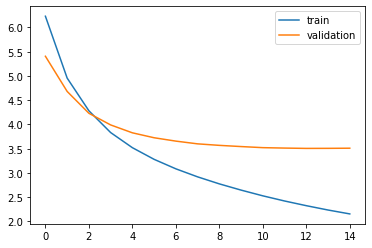

In [67]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [68]:
#model = load_model('model.h1.24_jan_19')
preds = model4.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [69]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [70]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [71]:
pd.set_option('display.max_colwidth', 200)

In [72]:
pred_df.head(15)

,actual,predicted
0,preserves must be stored in a jar with an airtight seal,warn with yourself
1,it rained for many days,rained during many days
2,dont smoke here,dont smoke here
3,tom asked mary why she was crying,mary for you crying
4,tom lived on the west coast,in the third west
5,its amazing,thats a
6,why dont you wear a dress,dont been a dress
7,he put his head out of the window,head for the window
8,i know the feeling,what he feeling
9,if you hadnt had my advice you would have failed,my advice failed


In [73]:
pred_df.tail(15)

,actual,predicted
23985,im waiting for my boyfriend,for my boyfriend
23986,im sorry i misunderstood you,sorry to you wrong
23987,im going to show you how its done,how is it done
23988,i would rather die than disgrace myself,to wear in ridiculous
23989,i told you to stay put,to you stay up
23990,ill call them tomorrow when i come back,ill when back tomorrow
23991,go now,go already
23992,no news is good news,news good news
23993,how was the weather yesterday,was on time yesterday
23994,i hope to hear from you soon,heard her from yourself


In [74]:
pred_df.tail(15)

,actual,predicted
23985,im waiting for my boyfriend,for my boyfriend
23986,im sorry i misunderstood you,sorry to you wrong
23987,im going to show you how its done,how is it done
23988,i would rather die than disgrace myself,to wear in ridiculous
23989,i told you to stay put,to you stay up
23990,ill call them tomorrow when i come back,ill when back tomorrow
23991,go now,go already
23992,no news is good news,news good news
23993,how was the weather yesterday,was on time yesterday
23994,i hope to hear from you soon,heard her from yourself


In [75]:
pred_df.sample(15)

,actual,predicted
10859,can you give us a minute,you a minute
14144,the best way to predict the future is to invent it,the future is complex
22745,thanks for pointing out the obvious,what is thinks
23396,i didnt know she was married,to she was married
21070,i ran into a parking meter last week,i the last week
16403,why would tom kill mary,tom mary
20501,we were caught in a shower on the way to school,going to school
5745,can you help look after the kids,care of the children
2352,that was unforgivable,thats was plain
5834,the sun was about to come up,to about to leave


* Voy a usar el mismo set de datos con GRU y en simpleRNN, vemos que las predicciones con RNN aciertan en algunas palabras pero por lo general, no traduce del todo bien.

# GRU MODEL

The encoder creates a matrix representation of the sentence. The decoder takes this matrix as input and predicts the translation as output.

In [47]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):   
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=False))
    model.add(Bidirectional(GRU(256,return_sequences=False)))
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(GRU(256,return_sequences=True)))
    model.add(TimeDistributed(Dense(out_vocab,activation='softmax')))
    return model

In [48]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
adam = optimizers.Adam(lr=0.001)#0.0005
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

In [51]:
trainX.shape #Usamos el trainX de size = 4

(96000, 4)

In [52]:
checkpoint = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') 
                                            # Evitar overfitting
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=100, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 76800 samples, validate on 19200 samples
Epoch 1/100
76800/76800 [==============================] - 309s 4ms/step - loss: 6.5008 - val_loss: 5.8596
Epoch 2/100
76800/76800 [==============================] - 305s 4ms/step - loss: 5.4231 - val_loss: 5.0619
Epoch 3/100
76800/76800 [==============================] - 307s 4ms/step - loss: 4.5363 - val_loss: 4.3331
Epoch 4/100
76800/76800 [==============================] - 316s 4ms/step - loss: 3.7387 - val_loss: 3.8453
Epoch 5/100
76800/76800 [==============================] - 318s 4ms/step - loss: 3.1029 - val_loss: 3.5414
Epoch 6/100
76800/76800 [==============================] - 312s 4ms/step - loss: 2.6156 - val_loss: 3.3550
Epoch 7/100
76800/76800 [==============================] - 323s 4ms/step - loss: 2.2299 - val_loss: 3.2299
Epoch 8/100
76800/76800 [==============================] - 312s 4ms/step - loss: 1.9214 - val_loss: 3.1723
Epoch 9/100
76800/76800 [==============================] - 320s 4ms/step - loss: 1.6714 - val_

In [53]:
#model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [54]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [55]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [56]:
pd.set_option('display.max_colwidth', 200)

In [57]:
pred_df.head(15)

,actual,predicted
0,preserves must be stored in a jar with an airtight seal,bag with custom carefully
1,it rained for many days,rained for many days
2,dont smoke here,dont cant smoke here
3,tom asked mary why she was crying,why he was crying
4,tom lived on the west coast,at the west coast
5,its amazing,thats incredible
6,why dont you wear a dress,not in a pen
7,he put his head out of the window,out of the window
8,i know the feeling,about what hes feel
9,if you hadnt had my advice you would have failed,my you missing lie


In [58]:
pred_df.tail(15)

,actual,predicted
23985,im waiting for my boyfriend,looking for my boyfriend
23986,im sorry i misunderstood you,sorry understand
23987,im going to show you how its done,how to do it
23988,i would rather die than disgrace myself,to get look seriously
23989,i told you to stay put,you keep quiet
23990,ill call them tomorrow when i come back,when to up tomorrow
23991,go now,go it
23992,no news is good news,news the news
23993,how was the weather yesterday,was the time yesterday
23994,i hope to hear from you soon,to her you soon


In [59]:
pred_df.tail(15)

,actual,predicted
23985,im waiting for my boyfriend,looking for my boyfriend
23986,im sorry i misunderstood you,sorry understand
23987,im going to show you how its done,how to do it
23988,i would rather die than disgrace myself,to get look seriously
23989,i told you to stay put,you keep quiet
23990,ill call them tomorrow when i come back,when to up tomorrow
23991,go now,go it
23992,no news is good news,news the news
23993,how was the weather yesterday,was the time yesterday
23994,i hope to hear from you soon,to her you soon


In [60]:
pred_df.sample(15)

,actual,predicted
2690,be careful about what you eat,about anything he eats
16439,this type of mobile phone sells well,your phone sells well
1465,we pay our bills at the end of the month,end of the month
286,i tried to be impartial,trying to jealous
9998,when do you want to start,you want to start
19591,tom was a great neighbor,a very good neighbor
20939,i assumed that it was free,assumed it was free
6784,the plates are dirty,these are dirty
23162,i am familiar with your name,your familiar to me
4955,theres hardly any hope that hell win the election,to win the election


Podemos ver que las predicciones no son muy malas, pero tiende a predecir mejor las frases cortas, además, por como se ha entrenado (con los datos de entrada con size = 4), tiende a predecir las frases largas con frases mucho más cortas.